__Автор__: Карпаев Алексей, ассистент кафедры информатики и вычислительной математики.

# Метод конечных разностей для численного решения ОДУ: программная реализация, ОО подход

## Математическая постановка задачи

В данной лекции будем рассматривать __задачу Коши для автономного ОДУ__:

$$ \frac{d u}{d t} = f\left(u \right), $$
$$ u \left( 0 \right) = u_0 $$
$$ t > 0 $$
В качестве конкретного примера возьмем __логистическое уравнение__ (по-другому __уравнение Ферхюльста__), имеющее правую часть следующего вида:
$$
f \left( u; \alpha, R \right) = \alpha \cdot u \left( 1 - \frac{u}{R} \right)
$$

Уравнение описывает динамику популяции с учетом влияния факторов окружающей среды (учтенных в параметрах $\alpha$ и $R$), ограничивающих экспоненциальный рост популяции со временем.

## Процесс численного решения уравнения
Производим дискретизацию расчетной области: вводим равномерную сетку с шагом $\Delta t = \frac{T}{N}$ c числом отрезков разбиения $N$. Для нахождения численного решения будем рассматривать следующий набор методов:
* Явный метод Эйлера (1-й порядок аппроксимации)
* Метод Хойна (2-й порядок аппроксимации)
* Метод Рунге-Кутты (4-й порядок аппроксимации).

Все методы являются __явными одношаговыми__ и относятся к семейству методов __Рунге-Кутты__.

## Программная реализация
### Процедурный подход

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=20)

In [2]:
class LogisticRightHandSide:
        
    def __init__(self, alpha, R):
        self._alpha = float(alpha)
        self._R = float(R)
    
    
    def __call__(self, u):
        return self._alpha*u*(1. - u/self._R)

In [4]:
# будем использовать функцию правой части со следующими значениями параметров
rhs1 = LogisticRightHandSide(alpha=0.2, R=100.)

In [5]:
# параметры сетки и уравнения
numBlocks = 30
tEnd = 80.
dt = float(tEnd)/numBlocks
initialValue = 2.

Реализация функций для численного решения различными методами:

In [6]:
def SolveViaExplicitEuler(f, tEnd, numBlocks, initialValue):
    dt = float(tEnd)/numBlocks
    timeArray = np.linspace(0, tEnd, numBlocks + 1)
    solutionArray = np.zeros(numBlocks + 1)
    
    solutionArray[0] = initialValue
    
    # шаги по времени
    for i in range(numBlocks):
        solutionArray[i + 1] = solutionArray[i] + dt*f(solutionArray[i])
    return timeArray, solutionArray

# запуск расчета
timeArrayEE, solutionArrayEE = SolveViaExplicitEuler(rhs1, tEnd, numBlocks, initialValue)

In [7]:
#############################################################################
def SolveViaHeun(f, tEnd, numBlocks, initialValue):
    dt = float(tEnd)/numBlocks
    timeArray = np.linspace(0, tEnd, numBlocks + 1)
    solutionArray = np.zeros(numBlocks + 1)
    
    solutionArray[0] = initialValue
    
    # шаги по времени
    for i in range(numBlocks):
        uStar = solutionArray[i] + dt*f(solutionArray[i])
        solutionArray[i + 1] = solutionArray[i] + dt/2. \
                            * (f(solutionArray[i]) + f(uStar))
    
    return timeArray, solutionArray

                            
# запуск расчета
timeArrayH, solutionArrayH = SolveViaHeun(rhs1, tEnd, numBlocks, initialValue)

In [8]:
###################################################################
def SolveViaRK4(f, tEnd, numBlocks, initialValue):
    dt = float(tEnd)/numBlocks
    timeArray = np.linspace(0, tEnd, numBlocks+1)
    solutionArray = np.zeros(numBlocks+1)
    
    solutionArray[0] = initialValue
    
    # шаги по времени
    for i in range(numBlocks):
        k1 = f(solutionArray[i])
        k2 = f(solutionArray[i] + dt/2.*k1)
        k3 = f(solutionArray[i] + dt/2.*k2)
        k4 = f(solutionArray[i] + dt*k3)
        
        solutionArray[i + 1] = solutionArray[i] + dt/6. * (k1 + 2.*k2 + 2.*k3 + k4)    
    
    return timeArray, solutionArray

# запуск расчета
timeArrayRK4, solutionArrayRK4 = SolveViaRK4(rhs1, tEnd, numBlocks, initialValue)

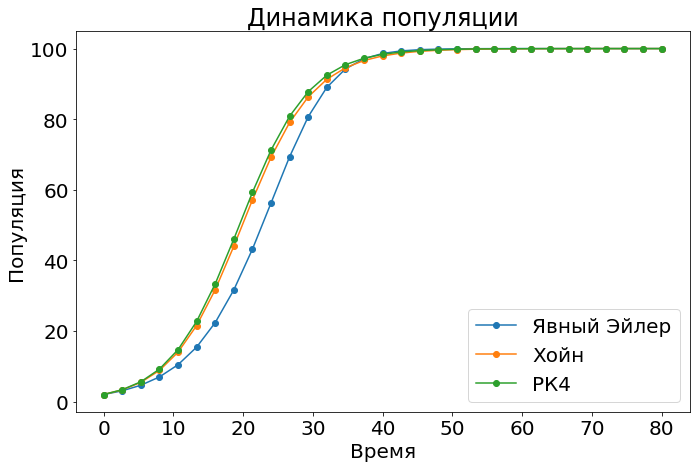

In [9]:
# построение графиков численных решений
plt.figure(figsize=(11,7))
plt.title('Динамика популяции')

plt.plot(timeArrayEE, solutionArrayEE, '-o', label='Явный Эйлер')
plt.plot(timeArrayH, solutionArrayH, '-o', label='Хойн')
plt.plot(timeArrayRK4, solutionArrayRK4, '-o', label='РК4')

plt.legend()
plt.xlabel('Время')
plt.ylabel('Популяция')
plt.grid('off')
plt.show()

Можно заметить, что у реализации каждого метода имеется много общего:
* задание параметров расчетной сетки
* задание начального условия
* цикл по точкам сетки.

### Объектно-ориентированный подход

Рассмотрим реализацию класса для проведения вычислений с помощью явного метода Эйлера. Класс __ExplicitEuler__:

__Поля__:
* функция правой части ОДУ
* начальное условие
* множество точек сетки и ее параметры: кол-во точек, отрезков, шаг сетки
* массив для хранения значений численного решения
* начальный и конечный моменты времени
* ...(по Вашему усмотрению)

__Методы__:
* конструктор: задать правую часть, начальное условие, параметры сетки
* решить ОДУ ("timestepping" - цикл по точкам сетки)
* построить график численного решения
* ...(по Вашему усмотрению)

In [12]:
import timeit # библиотека для замеров времени

class ExplicitEuler_ver1:
    
    def __init__(self, f, u0, numBlocks, tStart, tEnd):
        
        self.f = f
        self.u0 = u0
       
        self.numBlocks, self.numPoints = numBlocks, numBlocks + 1
        self.dt = (float(tEnd) - float(tStart))/self.numBlocks
        
        self.solutionArray = np.zeros(self.numPoints)
        self.timeArray = np.linspace(tStart, tEnd, self.numPoints)
        
        self.tStart, self.tEnd = float(tStart), float(tEnd)
        
        print('Объект класса ' + self.__class__.__name__ + ' создан.')
        
        
    
    def Solve(self):
        
        print('Начало расчета методом %s ...' % self.__class__.__name__)
        start = timeit.default_timer()
        
        # начальное условие
        self.solutionArray[0] = self.u0
        
        # шаги по времени
        for i in range(self.numBlocks):
            
            # для краткости
            uOld, dt, f = self.solutionArray[i], self.dt, self.f, 
                                
            # формула явного метода Эйлера 
            self.solutionArray[i + 1] = uOld + dt*f(uOld)
            
            # вывод на экран для отслеживания прогресса
            if ((i + 1) % (self.numBlocks//10) == 0):
                t = self.timeArray[i + 1]
                print('%.2f%% вычислений завершено' % (100.*float(t)/(self.tEnd - self.tStart)) )
                
            
            
        elapsedTime = float(timeit.default_timer() - start)
        print('Время расчета: %.2e сек.' % elapsedTime)
    
    
    def PlotSolution(self):
        plt.figure(figsize=(11,7))
        plt.plot(self.timeArray, self.solutionArray, '-', linewidth=4)
        plt.grid('off')
        plt.title('Решение методом %s ' % self.__class__.__name__)
        plt.xlabel('Время')
        plt.ylabel('Популяция')
        plt.show()

Функцию рассчета численного решения на неявном слое по времени можно оформить как отдельный метод класса __AdvanceNextStep__:

In [13]:
class ExplicitEuler_ver2:
    
    def __init__(self, f, u0, numBlocks, tStart, tEnd): # или задавать шаг dt?
        
        self.f = f
        self.u0 = u0
       
        self.numBlocks, self.numPoints = numBlocks, numBlocks + 1
        self.dt = (float(tEnd) - float(tStart))/float(self.numBlocks)
        
        self.solutionArray = np.zeros(self.numPoints)
        self.timeArray = np.linspace(tStart, tEnd, self.numPoints)
        
        self.tStart, self.tEnd = float(tStart), float(tEnd)
        
        
        print('Объект класса ' + self.__class__.__name__ + ' создан.')
        
  
    def Solve(self):
        
        print('Начало расчета методом %s ...' % self.__class__.__name__)
        start = timeit.default_timer()
        
        self.solutionArray[0] = self.u0
        
        # шаги по времени
        for i in range(self.numBlocks):
            
            # для краткости
            uOld, dt, f = self.solutionArray[i], self.dt, self.f
                                
            # формула явного метода Эйлера 
            self.solutionArray[i + 1] = self._AdvanceNextStep(i)
            
            # вывод на экран для отслеживания прогресса
            if ((i + 1) % (self.numBlocks//10) == 0):
                t = self.timeArray[i + 1]
                print('%.2f%% вычислений завершено' % (100.*float(t)/(self.tEnd - self.tStart)) )
                
            
            
        elapsedTime = float(timeit.default_timer() - start)
        print('Время расчета: %.2e сек.' % elapsedTime)
    
    ##### единственое отличие от предыдущей версии класса ################
    def _AdvanceNextStep(self, i):
        # для краткости
        uOld, dt, f = self.solutionArray[i], self.dt, self.f,  
        
        # формула явного метода Эйлера
        uNew = uOld + dt*f(uOld)
        
        return uNew
    ##############################################################
    
    def PlotSolution(self):
        plt.figure(figsize=(11,7))
        plt.plot(self.timeArray, self.solutionArray, '-o')
        plt.grid('off')
        plt.title('Решение методом %s ' % self.__class__.__name__)
        plt.xlabel('Время')
        plt.ylabel('Популяция')
        plt.show()

Теперь протестируем последнюю версию класса-солвера на логистическом уравнении. Как обычно: одинаковый набор методов различных солверов позволяет запускать их в одном цикле. Говорящие имена методов класса позволяют стороннему пользователю/разработчику разобраться в коде модуля, в котором обычно запускают расчеты:

Объект класса ExplicitEuler_ver2 создан.
Начало расчета методом ExplicitEuler_ver2 ...
10.00% вычислений завершено
20.00% вычислений завершено
30.00% вычислений завершено
40.00% вычислений завершено
50.00% вычислений завершено
60.00% вычислений завершено
70.00% вычислений завершено
80.00% вычислений завершено
90.00% вычислений завершено
100.00% вычислений завершено
Время расчета: 6.95e-04 сек.


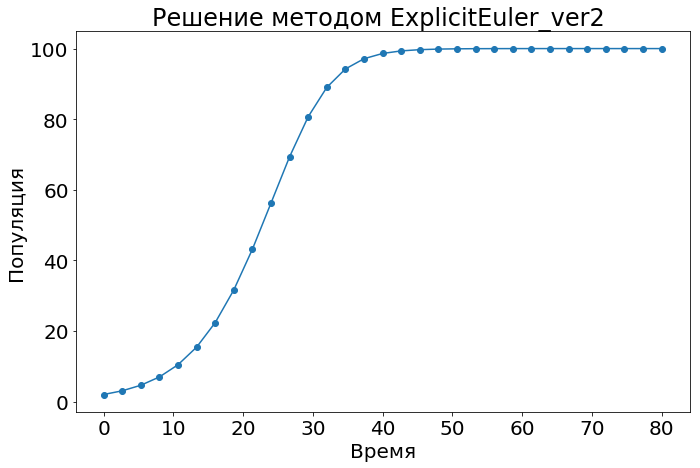

In [15]:
methodsClass = [ExplicitEuler_ver2]

# именнно такая реализация в HPL
for methodClass in methodsClass:
    # вызываем конструктор
    method = methodClass(f=rhs1, u0=2., numBlocks=30, tStart=0., tEnd=80.)
    
    method.Solve()
    method.PlotSolution()

## Вопросы?